In [ ]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-source-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-331-updates-uvm' for glob 'nvidi

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

--2020-11-10 07:17:36--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.0.24
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.0.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?F2ZmK4lUjHR_6S8yCZc1DGsTV0ppsIUFfJY-gsX7-YH8DnbO3Oi1HaRxie5cE8-pUcE7Zdszdi0kmMCRxazYw8YQmmJWS0OuBJtYnT6yfq6n3ZuT4marUUxZ24CrheuHdWYR3XX19R_1gHZg8oIWcBu3PxMDttJB1nbVhkso2XrciH7h-utJsXnHwN5-SQeofvUmIJBGTAJxDRaso-U [following]
--2020-11-10 07:17:36--  https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?F2ZmK4lUjHR_6S8yCZc1DGsTV0ppsIUFfJY-gsX7-YH8DnbO3Oi1HaRxie5cE8-pUcE7Zdszdi0kmMCRxazYw8YQmmJWS0OuBJtYnT6yfq6n3ZuT4marUUxZ24Cr

In [21]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Wed_Apr_11_23:16:29_CDT_2018
Cuda compilation tools, release 9.2, V9.2.88


In [22]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-th04ys2z
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-th04ys2z
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp36-none-any.whl size=4307 sha256=507d23fb72838eeb6a95312f48055ab2a16a2712b62b90a6323ae493e49c56a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-2d92v2y_/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


In [23]:
%load_ext nvcc_plugin

The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


In [27]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <iostream>
#include <cuda.h>
#include <algorithm>
#include <sys/time.h>
#define DSIZE 16384
#define RG    10000
#define k 69

#define nBLK  64
#define nTPB  256

#define cudaCheckErrors(msg) \
    do { \
        cudaError_t __err = cudaGetLastError(); \
        if (__err != cudaSuccess) { \
            fprintf(stderr, "Fatal error: %s (%s at %s:%d)\n", \
                msg, cudaGetErrorString(__err), \
                __FILE__, __LINE__); \
            fprintf(stderr, "*** FAILED - ABORTING\n"); \
            exit(1); \
        } \
    } while (0)



#define DESCEND true
#define ASCEND  false

struct timeval t1, t2;

template <bool descending, typename T>

__global__ void my_select(const T *data, const unsigned length, const unsigned select, volatile int *index){

  int idx = threadIdx.x+blockDim.x*blockIdx.x;

  while ((*index == -1) && (idx < length)){
    T my_val = data[idx];
    unsigned my_index = 0;
    
    // count the number of values higher (or lower) than the requested
    for (unsigned i = 0; i < length; i++){
        T temp = data[i];
        if (!descending){ // request to select item in descending order
          if (temp > my_val) my_index++;
          else if ((temp == my_val) && (i < idx)) my_index++; 
        }
        else {  // request to select item in ascending order
          if (temp < my_val) my_index++;
          else if ((temp == my_val) && (i < idx)) my_index++; 
        }
    }
    
    if (my_index == select) *index = idx;
    idx += blockDim.x*gridDim.x;
    }
}


int main(){

  int *h_data, *d_data, *d_result, h_result = -1;
  h_data = (int *)malloc(DSIZE*sizeof(int));

  if (h_data == NULL){
      printf("malloc fail\n"); 
      return -1;
  }
  
  cudaMalloc(&d_data, DSIZE*sizeof(int));
  cudaMalloc(&d_result, DSIZE*sizeof(int));
  cudaCheckErrors("cudaMalloc fail");
  
  for (int i =0; i < DSIZE; i++) //assign random values 
    h_data[i] = rand()%RG;

  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  cudaMemcpy(d_data, h_data, DSIZE*sizeof(int), cudaMemcpyHostToDevice);
  cudaMemcpy(d_result, &h_result, sizeof(int),   cudaMemcpyHostToDevice);
  cudaCheckErrors("cudaMemcpy fail");

  cudaEventRecord(start);
  my_select<DESCEND><<<nBLK, nTPB>>>(d_data, DSIZE, k, d_result); //ParallelProgrammming
  cudaEventRecord(stop);

  cudaMemcpy(&h_result, d_result, sizeof(int), cudaMemcpyDeviceToHost); // Copy Processed Results
  cudaCheckErrors("cudaMemcpy/kernel fail");
  printf("Size of input : %d\n",DSIZE);
  float milliseconds = 0;
  cudaEventElapsedTime(&milliseconds, start, stop);
  printf("Using ||el algorithms\nThe item index at select position %d is %d\nTime for processeing (in millisec) %f\n\n\n", k, h_data[h_result],milliseconds);
  
  // validation use inbuilt sorting 
  gettimeofday(&t1, 0);
  std::sort(h_data, h_data+DSIZE);
  gettimeofday(&t2, 0);
  float time = (1000000.0*(t2.tv_sec-t1.tv_sec) + t2.tv_usec-t1.tv_usec)/1000.0;
  printf("\nUsing Inbuilt Sort for validation \nThe item value at that sorted position is %d\nTime for processeing (in millisec) %f", h_data[k],time); // assumes DESCEND

  return 0;
}

Size of input : 16384
Using ||el algorithms
The item index at select position 69 is 37
Time for processeing (in millisec) 2.009088



Using Inbuilt Sort for validation 
The item value at that sorted position is 37
Time for processeing (in millisec) 3.136000


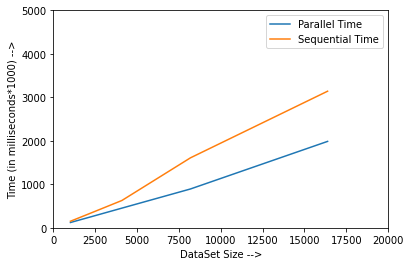

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt 
x = [1024,2048,4096,8192,16384]

y_p = [122,231.5,452.3,892.9,1987]
y_s = [151,309,628,1609,3141]
plt.plot(x, y_p, label = "Parallel Time")
plt.plot(x, y_s, label = "Sequential Time")
plt.xlabel("DataSet Size -->")
plt.ylabel("Time (in milliseconds*1000) -->")
plt.legend()
plt.xlim(0,20000)
plt.ylim(0,5000)
plt.show()